<a id="CGAN"><h1>Import Header</h1></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# %cd /content/drive/MyDrive/hoctap/NCKH/EVAGAN
%cd /content/drive/.shortcut-targets-by-id/1uUf7pXQHZlgN44q_V9w7kkIGdMJgNOXz/NCKH/EVAGAN
!pip install smote_variants lime shap > /dev/null 2>&1

!ln -fs /usr/share/zoneinfo/Asia/Ho_Chi_Minh /etc/localtime
!date '+%T %d/%m/%Y'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1uUf7pXQHZlgN44q_V9w7kkIGdMJgNOXz/NCKH/EVAGAN
16:52:45 27/06/2023


In [ ]:
# import importlib
# import header
# importlib.reload(header)
# from header import *
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

<a id="CGAN"><h1>Select GAN and Dataset and Flags</h1></a>

<a id="GPU Settings"><h2>Set Flags</h2></a>

In [ ]:
#@title Set Flags
#begin_from_start = 1 #@param {type:"integer"}
GAN_type = 'EVAGAN_CC' #@param ["EVAGAN_CC"]
DATA_SET = 'InSDN' #@param ["CIC-2018", "UNSW_BotIoT", "EdgeIIoT", "InSDN"]
ATTACH_IDS = True #@param {type:"boolean"}
# ATTACH_FED = False #@param {type:"boolean"}
with_transformer = False #@param {type:"boolean"}
take_chunk = 0 #@param {type:"integer"}
# required_epochs = 30 #@param {type:"integer"}
DISPLAY_FEATURES = 0 #@param {type:"integer"}
EVALUATION_PARAMETER = 'Accuracy'
# SAVE_ONLY_BOT_DATA = 0 #@param {type:"integer"}
# USE_KMEANS_FOR_CLASSIFICATION = 1 #@param {type:"integer"}


In [ ]:
labels =[]

print("GAN type:", GAN_type)
print("Dataset:", DATA_SET)
print("Train With Transformer:", with_transformer)
USE_KMEANS_FOR_CLASSIFICATION = 1
if ATTACH_IDS:
    required_epochs = 30
else:
    required_epochs = 50

GAN type: EVAGAN_CC
Dataset: InSDN
Train With Transformer: False


<a id="CGAN"><h1>Set Paths & Variables</h1></a>

In [ ]:
MAIN_CODE_PATH = os.getcwd()
DATA_SET_PATH = MAIN_CODE_PATH + "/dataset/" + DATA_SET + "/"
TODAY = str(datetime.datetime.today().strftime('%Y-%m-%d'))
NOW = str(datetime.datetime.today().strftime('%H_%M_%S'))
RESULT_PATH = MAIN_CODE_PATH + '/results/' + TODAY + '/'
FIGS_PATH = MAIN_CODE_PATH  + '/figs/' + TODAY + '/'
SUBPATH = DATA_SET + '_' + NOW
%mkdir -p $RESULT_PATH
%cd $DATA_SET_PATH

/content/drive/.shortcut-targets-by-id/1uUf7pXQHZlgN44q_V9w7kkIGdMJgNOXz/NCKH/EVAGAN/dataset/InSDN


<a id="GPU Settings"><h2>Check Available GPUs</h2></a>

<a id="GPU Settings"><h2>Import Dataset</h2></a>

In [ ]:
if DATA_SET == 'CIC-2018':
    DATA_TRAIN = DATA_SET_PATH + "preprocessed_Friday-02-03-2018_TrafficForML_CICFlowMeter.csv"
elif DATA_SET == 'EdgeIIoT':
    DATA_TRAIN = DATA_SET_PATH + "preprocessed_DNN-EdgeIIoT-dataset.csv"
elif DATA_SET == "InSDN":
    DATA_TRAIN = DATA_SET_PATH + "preprocessed_InSDN.csv"

training_data = pd.read_csv(DATA_TRAIN, low_memory=False, index_col=0)
training_data = training_data.replace([np.inf, -np.inf], np.nan).dropna(how="any").reset_index(drop=True)
testing_data = training_data

training_data.info()
num_samples = training_data.shape[0]
print(f"Number of samples: {num_samples}")
label_column = training_data['Label'].value_counts('1')
label_count = training_data['Label'].value_counts()


print(label_column)
print(label_count)

print('Dataset Imported: ' + DATA_SET)
print('Training set: '+ str(training_data.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70979 entries, 0 to 70978
Data columns (total 51 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DstPort         70979 non-null  int64  
 1   Protocol        70979 non-null  int64  
 2   FlowDuration    70979 non-null  int64  
 3   TotFwdPkts      70979 non-null  int64  
 4   TotBwdPkts      70979 non-null  int64  
 5   TotLenFwdPkts   70979 non-null  float64
 6   TotLenBwdPkts   70979 non-null  float64
 7   FwdPktLenMax    70979 non-null  int64  
 8   FwdPktLenMin    70979 non-null  int64  
 9   FwdPktLenMean   70979 non-null  float64
 10  FwdPktLenStd    70979 non-null  float64
 11  BwdPktLenMax    70979 non-null  int64  
 12  BwdPktLenMean   70979 non-null  float64
 13  BwdPktLenStd    70979 non-null  float64
 14  FlowBytss       70979 non-null  float64
 15  FlowPktss       70979 non-null  float64
 16  FlowIATMean     70979 non-null  float64
 17  FlowIATStd      70979 non-null 

<a id="GPU Settings"><h2>Display Features</h2></a>

In [ ]:
DISPLAY_FEATURES = False
if DISPLAY_FEATURES:
    unified_df = training_data.copy()
    X_cols = unified_df.columns[:-1]
    y_cols = unified_df.columns[-1]

    axarr = [[]]*len(X_cols)
    columns = 4
    rows = int( np.ceil( len(X_cols) / columns ) )
    f, fig = plt.subplots( figsize=(columns*2.5, rows*2) )

    f.suptitle('Data Distributions by Feature and Label', size=16)

    for i, col in enumerate(X_cols[:]):
        axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )


        axarr[i].hist( unified_df.loc[ unified_df.Label == 0, col ] , label=['Normal'], color=('#009933'), alpha=0.5,
                              bins=np.linspace( np.percentile(unified_df[col],0), np.percentile(unified_df[col],100),50 ),
                              density=True )

        axarr[i].hist( unified_df.loc[ unified_df.Label == 1, col ] , label=['Real Bot'], color=['#FF0000'], alpha=0.5,
                              bins=np.linspace( np.percentile(unified_df[col],0), np.percentile(unified_df[col],100),50 ),
                              density=True )

        axarr[i].set_xlabel(col, size=12)
    #     axarr[i].set_ylim([0,1])
        axarr[i].tick_params(axis='both', labelsize=10)
        if i == 0:
            legend = axarr[i].legend()
            legend.get_frame().set_facecolor('white')
        if i%4 != 0 :
            axarr[i].tick_params(axis='y', left=True, labelleft=True)
        else:
            axarr[i].set_ylabel('Fraction',size=12)

    plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
    # tmp_path = RESULT_PATH + SUBPATH + '/' + SUBPATH
    # plt.savefig(RESULT_PATH + NOW + '_Engineered_Data_Distributions.png')
    plt.show()

<a id="GPU Settings"><h2>Select Botnet</h2></a>

In [ ]:
bots = training_data.loc[ training_data['Label']==1 ].copy()
normal = training_data.loc[ training_data['Label']==0 ].copy()

print('Normal before chunk: ' + str(normal.shape))
print('Real Bots before chunk: ' + str(bots.shape))

threshold = 20 # normal / botnet

num_normal = threshold * bots.shape[0]
normal = normal[0:num_normal]

if DATA_SET == "EdgeIIoT":
    take_chunk = True
    base_bot = 3072
elif  DATA_SET == "InSDN":
    take_chunk = True
    base_bot = 1280

if take_chunk:
    normal = normal[0:(threshold * base_bot)]
    bots = bots[0:base_bot]

print('Normal: ' + str(normal.shape))
print('Real Bots: ' + str(bots.shape))

Normal before chunk: (68419, 51)
Real Bots before chunk: (2560, 51)
Normal: (25600, 51)
Real Bots: (1280, 51)


In [ ]:
Train = training_data.copy()

In [ ]:
bots_count =  pd.DataFrame( [ [np.sum(bots['Label']==i)] for i in np.unique(bots['Label']) ], columns=['count'], index=np.unique(bots['Label']) )

label_cols = [ i for i in bots.columns if 'Label' in i ]
data_cols = [ i for i in bots.columns if i not in label_cols ]

train_no_label = bots[ data_cols ].reset_index(drop=True)

print(bots_count['count'])

1    1280
Name: count, dtype: int64


In [ ]:
train_data = bots

<a id="Classification"><h1>Classification</h1></a>

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


1280
CPU times: user 438 ms, sys: 216 ms, total: 654 ms
Wall time: 538 ms


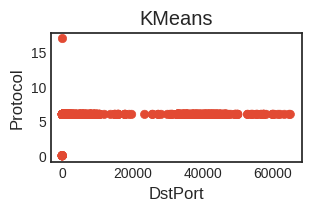

In [ ]:
%%time
if USE_KMEANS_FOR_CLASSIFICATION:
    algorithms = [
        [ 'KMeans', cluster.KMeans, (), {'n_clusters':1, 'random_state':0} ],
    ]

    rows = len(algorithms)
    columns = 1
    fig, ax = plt.subplots(3, 2, figsize=(3, 2), constrained_layout=True)

    for i, [name, algorithm, args, kwds] in enumerate(algorithms):

        labels = algorithm(*args, **kwds).fit_predict(train_no_label)
        print(len(labels))
        colors = np.clip(labels,-1,9)
        colors = [ 'C'+str(i) if i>-1 else 'white' for i in colors ]

        plt.subplot(rows,columns,i*columns+1)
        plt.scatter(train_no_label[data_cols[0]], train_no_label[data_cols[1]], c=colors)
        plt.xlabel(data_cols[0]), plt.ylabel(data_cols[1])
        plt.title(name)

    botnet_w_classes = train_no_label.copy()
    botnet_w_classes['Label'] = labels

#     print(botnet_w_classes.describe())
    train_data = botnet_w_classes

# else:
#     train_data = train_no_label


<a id="GPU Settings"><h2>GAN Training</h2></a>

In [ ]:
# import header
# import importlib
# from header import *

gpu_device = '/device:GPU:2'
physical_devices = tf.config.list_physical_devices('GPU')
for gpu_instance in physical_devices:
    tf.config.experimental.set_memory_growth(gpu_instance, True)

#----------------------------------
# Set neurons and batch size
#----------------------------------
if DATA_SET == 'CIC-2018':
    base_n_count = 128
    batch_size =  128
elif DATA_SET == 'InSDN':
    base_n_count = 256
    batch_size =  256
elif DATA_SET == "EdgeIIoT":
    base_n_count = 512
    batch_size = 512
#----------------------------------

result = train_data
remaining = train_data.shape[0] % batch_size

if remaining > 0:
    if remaining < train_data.shape[0]:
        additional = batch_size - remaining
        _additional = train_data.loc[train_data.shape[0]-additional:train_data.shape[0],: ]

        frames = [train_data, _additional]
        result = pd.concat(frames).reset_index(drop=True)

print('Result: ', str(result.shape))
# ---------------------------------
nb_steps = required_epochs * result.shape[0] // batch_size
log_interval = result.shape[0] // batch_size # We are setting this as an epoch. This depends on data size.

print("log_interval : " + str(log_interval))

# nb_steps = TRAINING_ITERATIONS  # 50000 # Add one for logging of the last interval
print("Total Batch Iterations: " + str(nb_steps))
rand_noise_dim = 64

k_d = 3  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step

critic_pre_train_steps = 100# 100  # number of steps to pre-train the critic before starting adversarial training
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

show = True
train = result#.copy().reset_index(drop=True) # botnet only with labels from classification

label_cols = [ i for i in train.columns if 'Label' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
print(data_cols)
train_no_label = train[ data_cols ]
train_no_label = round(train_no_label, 4)

test_size = train.shape[0]

learning_rate = 5e-4

for X in range(1):
    NOW_NAME = DATA_SET + '_' + NOW

    print(NOW_NAME)

    Test = testing_data.copy()

    arguments = [rand_noise_dim, nb_steps, batch_size,
                k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count, threshold, ATTACH_IDS,
                RESULT_PATH, FIGS_PATH, show, test_size, gpu_device, EVALUATION_PARAMETER, NOW_NAME ]

    best_losses = train_EVAGAN_CC(arguments, train, Train, Test, data_cols, with_transformer)

Result:  (1280, 51)
log_interval : 5
Total Batch Iterations: 150
['DstPort', 'Protocol', 'FlowDuration', 'TotFwdPkts', 'TotBwdPkts', 'TotLenFwdPkts', 'TotLenBwdPkts', 'FwdPktLenMax', 'FwdPktLenMin', 'FwdPktLenMean', 'FwdPktLenStd', 'BwdPktLenMax', 'BwdPktLenMean', 'BwdPktLenStd', 'FlowBytss', 'FlowPktss', 'FlowIATMean', 'FlowIATStd', 'FlowIATMax', 'FlowIATMin', 'FwdIATTot', 'FwdIATMean', 'FwdIATStd', 'FwdIATMax', 'FwdIATMin', 'BwdIATTot', 'BwdIATMean', 'BwdIATStd', 'BwdIATMax', 'BwdIATMin', 'BwdPSHFlags', 'FwdHeaderLen', 'BwdHeaderLen', 'FwdPktss', 'BwdPktss', 'PktLenMin', 'PktLenMax', 'PktLenMean', 'PktLenStd', 'FINFlagCnt', 'SYNFlagCnt', 'RSTFlagCnt', 'ACKFlagCnt', 'PktSizeAvg', 'InitBwdWinByts', 'ActiveMean', 'ActiveMin', 'IdleMean', 'IdleMax', 'IdleMin']
InSDN_16_52_45
With_Trainformer: False
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 32

KeyboardInterrupt: ignored

<a id="Visualization"><h1>Visualization</h1></a>

In [ ]:
RESULT_PATH = MAIN_CODE_PATH + '/results/' + TODAY + '/' + SUBPATH + '/'
CSV_PATH = RESULT_PATH + 'EVAGAN_CC_LISTS.csv'
CLASSIFIER_PATH = RESULT_PATH + "classifier"
CLASSIFIER_LIST_PATH = RESULT_PATH + 'CLASSIFIER_LISTS.csv'
ESTIMATION_PATH = RESULT_PATH + "/EVAGAN_Estimations.png"
D_LOSS_PATH = RESULT_PATH + "/EVAGAN_D_Loss.png"
D_G_LOSS_PATH = RESULT_PATH + "/EVAGAN_D_G_Loss.png"

EVAGAN_Estimations = pd.read_csv(CSV_PATH, low_memory=False, usecols=[1, 2, 3, 4])
D_Loss = pd.read_csv(CSV_PATH, low_memory=False, usecols=[5, 6, 7])
D_G_Loss = pd.read_csv(CSV_PATH, low_memory=False, usecols=[5, 6, 7, 8])

In [ ]:
# VISUALIZATION
def visualize_GAN(data, ncol, bbox_to_anchor):
  fig, ax = plt.subplots()
  # plt.style.use('default')

  for col in np.array(data.columns):
    ax.plot(data[str(col)], label=col)

  ax.plot(style={'GEN_VALIDITY': 'DarkBlue',
                 'REAL_NORMAL_EST': 'DarkGreen',
                 'FAKE_BOT_EVA': 'DarkOrange',
                 'REAL_BOT_EVA': 'DarkRed',
                 'D_Loss_Real_Bot': 'DarkBlue',
                 'D_Loss_Fake_Bot': 'DarkGreen',
                 'D_Loss_Real_Normal': 'DarkOrange',
                 'D_Loss': 'DarkYellow',
                 'G_Loss': 'DarkRed',})

  leg = ax.legend(loc="lower left", bbox_to_anchor=bbox_to_anchor, mode='expand', ncol=ncol, shadow=True, title="EVAGAN", fancybox=True)
  leg.get_title().set_color("red")
  plt.tight_layout()

  if data.columns[0] == 'GEN_VALIDITY':
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('%', fontsize=14)
    plt.savefig(ESTIMATION_PATH)
  elif data.columns[0] == 'D_Loss_Real_Bot':
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.savefig(D_LOSS_PATH)
  elif data.columns[0] == "D_Loss":
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.savefig(D_G_LOSS_PATH)
  plt.show()
  plt.clf()

In [ ]:
def visualize_classifier(path, classifier, output_path):
    df = pd.read_csv(path)
    df.rename(columns={df.columns[0]: 'epoch'}, inplace=True)

    metrics_cols = [col for col in df.columns if classifier in col]

    plt.figure(figsize=(10, 6))

    plt.plot(df['epoch'], df[f"{classifier}_FNR"].round(6), marker='o', label="FNR")
    plt.plot(df['epoch'], df[f"{classifier}_FPR"].round(6), marker='o', label="FPR")
    plt.plot(df['epoch'], df[f"{classifier}_DR"].round(6), marker='o', label="DR")

    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.ylim(-0.1, 1.1)
    plt.title(f'{classifier} FNR_FPR_DR Metrics')
    plt.legend()
    plt.savefig(output_path + f"/{classifier}_FNR_FPR_DR_metrics.png")
    plt.show()

    plt.figure(figsize=(10, 6))

    plt.plot(df['epoch'], df[f"{classifier}_recall"].round(6), marker='o', label="recall")
    plt.plot(df['epoch'], df[f"{classifier}_precision"].round(6), marker='o', label="precision")

    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.ylim(-0.1, 1.1)
    plt.title(f'{classifier} Recall-Precision Metrics')
    plt.legend()
    plt.savefig(output_path + f"/{classifier}_rec_pre_metrics.png")
    plt.show()

In [ ]:
if ATTACH_IDS:
    classifier_list = ["XGB", "LGBM", "LR"]

    for c in classifier_list:
        visualize_classifier(CLASSIFIER_LIST_PATH, c, CLASSIFIER_PATH)

In [ ]:
bbox_estimations = [0.05, 1.02, 0.9, 1]
visualize_GAN(EVAGAN_Estimations, ncol=2, bbox_to_anchor=bbox_estimations)

In [ ]:
bbox_loss = [0.5, 1.02, 0.5, 1]
visualize_GAN(D_Loss, ncol=1, bbox_to_anchor=bbox_loss)

In [ ]:
bbox_loss = [0.5, 1.02, 0.5, 1]
visualize_GAN(D_G_Loss, ncol=1, bbox_to_anchor=bbox_loss)